## Intent Classification with BERT

In [1]:
# Required Python 3.10 version 
import os
import random
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import transformers
from transformers import AutoModel, AutoTokenizer
from transformers import AdamWeightDecay, AdamW, get_linear_schedule_with_warmup
from adamp import AdamP
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TextClassificationPipeline 

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.cuda.amp as amp # for faster training

import matplotlib.pyplot as plt
import seaborn as sns

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import wandb
from pytorch_lightning.loggers import WandbLogger

/opt/conda/envs/howcanai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- KoElectra ( KcVBERT에서 파생된 KcElectra 도 있음.)   
  https://huggingface.co/monologg/koelectra-base-v3-discriminator  
  https://github.com/monologg/KoELECTRA

  
- KLUE-RoBERTa (진행 중)  
  https://huggingface.co/klue/roberta-large  
  https://github.com/KLUE-benchmark/KLUE

In [2]:
informational_intent = ['무엇을','누가','언제','어디서','왜','어떻게',]
navigational_intent = [] 
commercial_intent = ['베스트', '탑','리뷰','비교',] 
transactional_intent = ['구매','가격','티켓','세일']

In [3]:
# class Config:
#     model: str= 'klue/roberta-large'
#     data_path: str =  '/opt/ml/final/data/'
#     n_classes: int= 20
#     ckpt_path: str = './ckpt/'
#     seed: int = 42
#     batch_size: int = 128
#     max_len: int = 128
#     lr: float = 1e-3
#     optimizer: str = 'AdamW'
#     max_epochs: int = 100
#     use_cuda: bool = True
#     test_mode: bool = False
#     warmup_steps: int = 0
#     adam_eps: float = 1e-8
#     # weight_decay: float = 

# config = Config()

In [4]:
parser = argparse.ArgumentParser(description='Intent Classification with BERT')

parser.add_argument('--model', type=str, default='klue/roberta-base', help='pretrained model name')
parser.add_argument('--data_path', type=str, default='/opt/ml/howcan.ai/data')
parser.add_argument('--n_classes', type=int, default=20)
parser.add_argument('--ckpt_path', type=str, default='./ckpt/')
parser.add_argument('--seed',type=int, default=42)
parser.add_argument('--batch_size', type=int, default=256)
parser.add_argument('--max_len', type=int, default=40)
parser.add_argument('--lr', type=float, default=1e-5)
parser.add_argument('--optimizer', type=str, default='AdamP')
parser.add_argument('--max_epochs', type=int, default=10)
parser.add_argument('--use_cuda', type=bool, default=True)
parser.add_argument('--test_mode', type=bool, default=False)
parser.add_argument('--warmup_steps', type=int, default=0)
parser.add_argument('--adam_eps', type=float, default=1e-8)

config = parser.parse_args([])

In [5]:
def seed_everything(seed):
    # pl에서 함수 제공하긴 함.
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # for faster training

seed_everything(seed=config.seed)

In [6]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: watchstep (watchstep_). Use `wandb login --relogin` to force relogin


True

### Data

In [7]:
# df1 = pd.read_csv(os.path.join(config.data_path, '가전제품.csv'))
# df2 = pd.read_csv(os.path.join(config.data_path, '건강_및_의학.csv'))
# df3 = pd.read_csv(os.path.join(config.data_path, '과학_및_기술.csv'))
# df4 = pd.read_csv(os.path.join(config.data_path, '대중교통_및_지도.csv'))
# df5 = pd.read_csv(os.path.join(config.data_path, '식품_및_요리_레시피.csv'))
# df6 = pd.read_csv(os.path.join(config.data_path, '여행_및_관광.csv'))
# df7 = pd.read_csv(os.path.join(config.data_path, '여행_예약.csv'))
# df8 = pd.read_csv(os.path.join(config.data_path, '역사.csv'))
# df9 = pd.read_csv(os.path.join(config.data_path, '예약_및_예매.csv'))
# df10 = pd.read_csv(os.path.join(config.data_path, '웹사이트_웹_검색.csv'))
# df11 = pd.read_csv(os.path.join(config.data_path, '음식_주문_및_배달.csv'))
# df12 = pd.read_csv(os.path.join(config.data_path, '이벤트_티켓_예매.csv'))
# df13 = pd.read_csv(os.path.join(config.data_path, '인물_정보.csv'))
# df14 = pd.read_csv(os.path.join(config.data_path, '일반_지식.csv'))
# df15 = pd.read_csv(os.path.join(config.data_path, '정치_사회_경제.csv'))
# df16 = pd.read_csv(os.path.join(config.data_path, '제품_가격_비교.csv'))
# df17 = pd.read_csv(os.path.join(config.data_path, '제품_구매.csv'))
# df18 = pd.read_csv(os.path.join(config.data_path, '제품_리뷰.csv'))
# df19 = pd.read_csv(os.path.join(config.data_path, '호텔_및_숙박.csv'))
# df20 = pd.read_csv(os.path.join(config.data_path, '패션_및_뷰티.csv'))

In [8]:
# # 데이터 합치고 파일로 저장하고 이후 진행
# intent_data = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20])
# intent_data.drop_duplicates(inplace=True)

# # save
# # intent_data.to_csv(os.path.join(config.data_path, 'intent_data.csv'), index=False)
# intent_data.info()

In [9]:
def load_data(data_path, train_mode: bool=True):
    if train_mode: 
        data = pd.read_csv(os.path.join(data_path, 'data.csv'))
    else:
        data = pd.read_csv(os.path.join(data_path, 'test_data.csv'))
    return data

data = load_data(data_path=config.data_path)
test_data = load_data(data_path=config.data_path, train_mode=False)

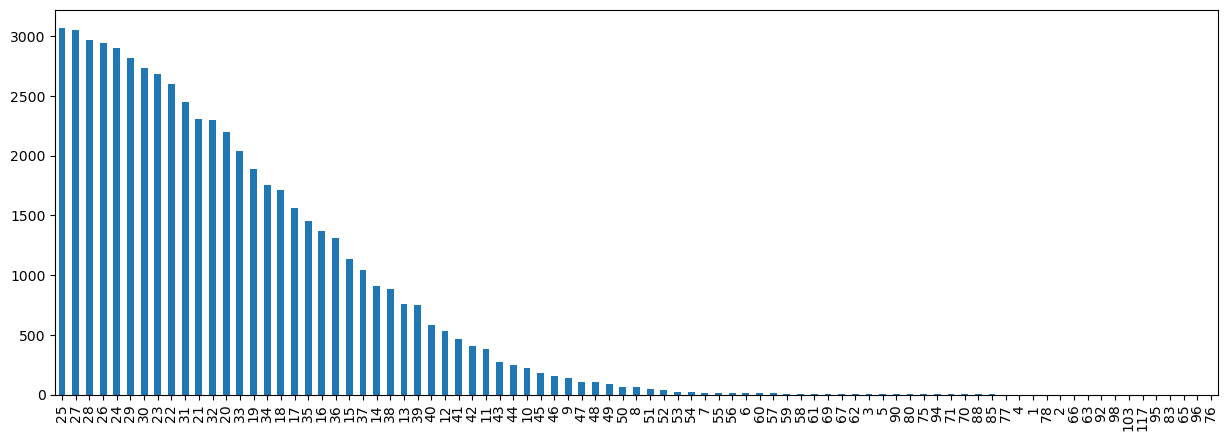

In [10]:
plt.figure(figsize=(15, 5))
data_sentence_length = data['query'].apply(len)
data_sentence_length.value_counts().plot.bar();

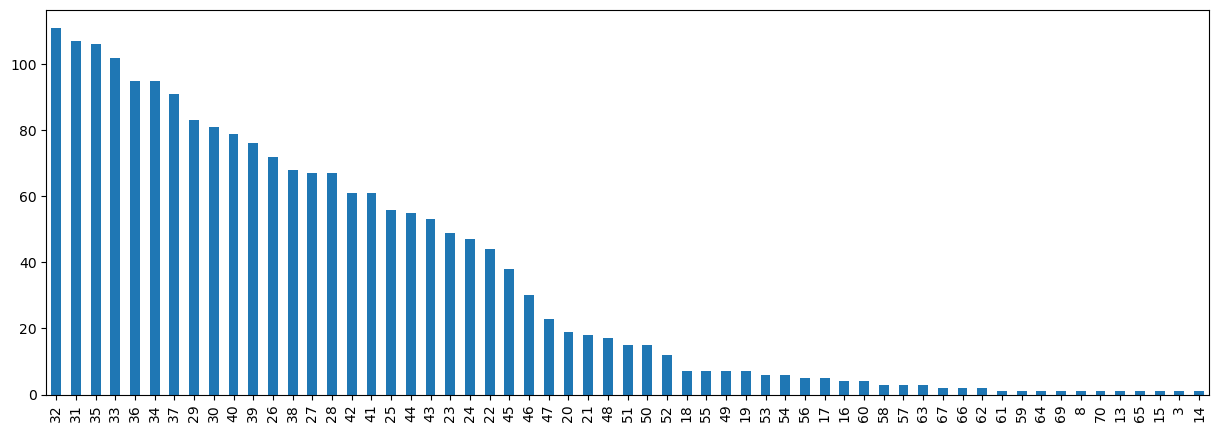

In [11]:
plt.figure(figsize=(15, 5))
data_sentence_length = test_data['query'].apply(len)
data_sentence_length.value_counts().plot.bar();

In [12]:
# label encoding
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])
test_data['label'] = le.fit_transform(test_data['label'])

le.classes_

array(['거래 의도 (Transactional Intent) - 여행 예약 (Travel Reservations)',
       '거래 의도 (Transactional Intent) - 예약 및 예매 (Reservations and Bookings)',
       '거래 의도 (Transactional Intent) - 음식 주문 및 배달 (Food Ordering and Delivery)',
       '거래 의도 (Transactional Intent) - 이벤트 티켓 예매 (Event Ticket Booking)',
       '거래 의도 (Transactional Intent) - 제품 구매 (Product Purchase)',
       '네비게이셔널 의도 (Navigational Intent) - 대중교통 및 지도 (Public Transportation and Maps)',
       '네비게이셔널 의도 (Navigational Intent) - 여행 및 관광 (Travel and Tourism)',
       '네비게이셔널 의도 (Navigational Intent) - 웹사이트/앱 검색 (Website/App Search)',
       '네비게이셔널 의도 (Navigational Intent) - 호텔 및 숙박 (Hotels and Accommodation)',
       '상업적 정보 조사 의도 (Commercial Intent) - 가전제품 (Electronics)',
       '상업적 정보 조사 의도 (Commercial Intent) - 식품 및 요리 레시피 (Food and Recipe)',
       '상업적 정보 조사 의도 (Commercial Intent) - 제품 가격 비교 (Product Price Comparison)',
       '상업적 정보 조사 의도 (Commercial Intent) - 제품 리뷰 (Product Reviews)',
       '상업적 정보 조사 의도 (Commerci

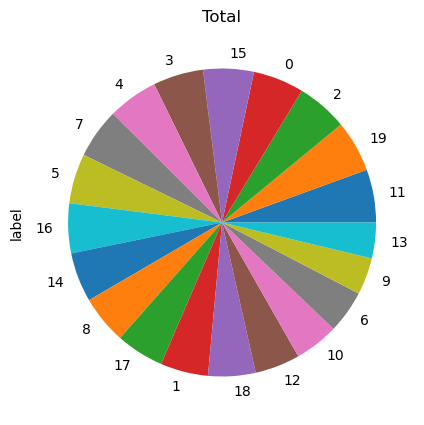

In [13]:
plt.figure(figsize=(5, 5))
data['label'].value_counts().plot.pie()
plt.title('Total');

In [14]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=config.seed, stratify=data['label']) 
# test_data = test_data.sample(frac=1).reset_index(drop=True)

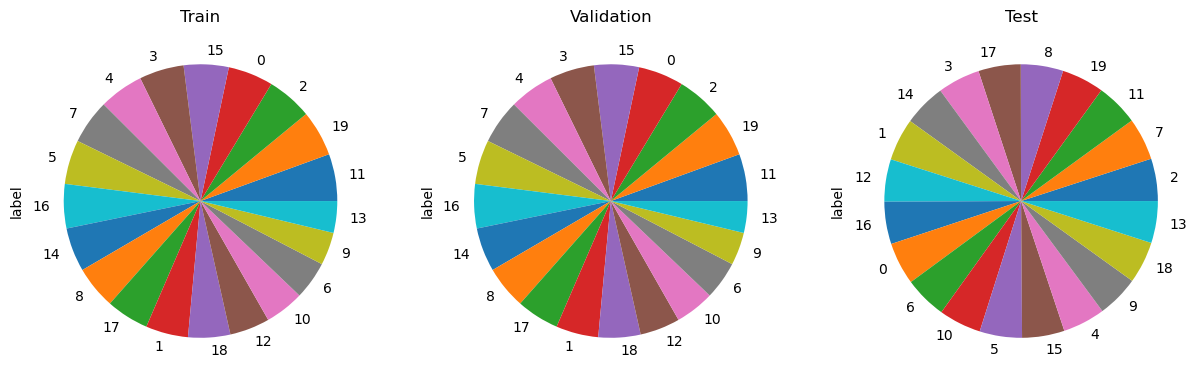

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
train_data['label'].value_counts().plot.pie(ax=ax[0]);
ax[0].set_title('Train')
val_data['label'].value_counts().plot.pie(ax=ax[1]);
ax[1].set_title('Validation')
test_data['label'].value_counts().plot.pie(ax=ax[2]);
ax[2].set_title('Test');

In [16]:
print('========== Before ===========')
print(f'# of Train Data : {len(train_data)}')
print(f'# of Validation Data : {len(val_data)}')
print(f'# of Test Data : {len(test_data)} \n')

# 중복 제거
train_data.drop_duplicates(subset=['query'], inplace= True)
val_data.drop_duplicates(subset=['query'], inplace= True)
test_data.drop_duplicates(subset=['query'], inplace= True)

# Null 제거
train_data['query'].replace('', np.nan, inplace=True)
val_data['query'].replace('', np.nan, inplace=True)
test_data['query'].replace('', np.nan, inplace=True)
train_data = train_data.dropna()
val_data = val_data.dropna()
test_data = test_data.dropna()

print('========== After ===========')
print(f'# of Train Data : {len(train_data)}')
print(f'# of Validation Data : {len(val_data)}')
print(f'# of Test Data : {len(test_data)}')

========== Before ===========
# of Train Data : 46284
# of Validation Data : 11572
# of Test Data : 1997 

========== After ===========
# of Train Data : 46244
# of Validation Data : 11569
# of Test Data : 1997


In [17]:
class IntentDataset(Dataset):
    def __init__(self, data, max_len, mode='train'):
        super(IntentDataset, self).__init__()
        self.data = data
        self.max_len = max_len
        self.mode = mode
        self.tokenizer = AutoTokenizer.from_pretrained(config.model)
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        query = self.data.iloc[idx]['query']
        label = self.data.iloc[idx]['label']
        
        tokens = self.tokenizer.encode_plus(
            query,
            return_tensors='pt',
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            # pad_to_max_length=True,
            add_special_tokens=False
        )
        
        input_ids = tokens['input_ids'].squeeze(0) 
        attention_mask = tokens['attention_mask'].squeeze(0)
        token_type_ids = torch.zeros_like(attention_mask)
        
        # if self.mode == 'train':
        #     return output, torch.tensor(label)
        
        #  return {'input_ids': input_ids,
        #           'attention_mask': attention_mask, 
        #         }
        
        return {'input_ids': input_ids,
                'attention_mask': attention_mask, 
                'token_type_ids': token_type_ids,
                'label': torch.tensor(label),
                }

In [18]:
class IntentDataModule(LightningModule):
    def __init__(self, train_data, val_data, test_data, max_len, batch_size):
        super(IntentDataModule, self).__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.max_len = max_len
        self.batch_size = batch_size
    
    def setup(self, stage=None):
        self.train_dataset = IntentDataset(
            self.train_data,
            self.max_len
        )
        self.val_dataset = IntentDataset(
            self.val_data,
            self.max_len
        )
        self.test_dataset = IntentDataset(
            self.test_data,
            self.max_len
        )
        
    # num_workers => os.cpu_count()
    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=8
        )
        
    def val_dataloader(self):
        return DataLoader(
            dataset=self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=8
        )
        
    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=8
        )

In [19]:
data_module = IntentDataModule(train_data=train_data,
                               val_data=val_data,
                               test_data=test_data,
                               max_len=config.max_len,
                               batch_size=config.batch_size)

data_module.setup()

In [20]:
batch = next(iter(data_module.train_dataloader()))
print(batch['input_ids'])
print(batch['input_ids'].shape)

tensor([[ 7095, 27135,  7833,  ...,     1,     1,     1],
        [ 4335,  2256,  2372,  ...,     1,     1,     1],
        [14004, 15373,  2259,  ...,     1,     1,     1],
        ...,
        [ 4628,  2140,  2069,  ...,     1,     1,     1],
        [15419,  2440,  5272,  ...,     1,     1,     1],
        [ 8997,  2069,  4520,  ...,     1,     1,     1]])
torch.Size([256, 40])


### Model

In [21]:
class IntentCLSModel(LightningModule):
    def __init__(self, config):
        super(IntentCLSModel, self).__init__()
        self.save_hyperparameters() # self.hparams에 config 저장됨.
        self.validation_step_outputs = []
        self.test_step_outputs = []
        
        self.config = config
        self.bert = AutoModel.from_pretrained(self.config.model)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.config.n_classes)
        self.criterion = nn.CrossEntropyLoss()
        
        # for parameter in self.bert.parameters():
        #     parameter.requires_grad = False
        # for parameter in self.bert.encoder.layer[-1].parameters():
        #     parameter.requires_grad = True
            
    
    def forward(self, *args):
        output = self.bert(*args)
        pred = self.fc(output.pooler_output)
        
        return pred
    
    def configure_optimizers(self):
        assert self.config.optimizer in ['AdamW', 'AdamP'], 'Only AdamW, AdamP'
        
        if self.config.optimizer == 'AdamW':
            optimizer = AdamW(self.parameters(), lr=self.config.lr, eps=self.config.adam_eps)
        elif self.config.optimizer == 'AdamP':
            optimizer = AdamP(self.parameters(), lr=self.config.lr, eps=self.config.adam_eps)
            
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.config.warmup_steps,
            num_training_steps=self.trainer.estimated_stepping_batches,
        )
            
        return {'optimizer': optimizer,
                'scheduler': scheduler
                }
          
    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        y = batch['label']
        y_hat = self.forward(input_ids, attention_mask)
        
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, on_epoch=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        y = batch['label']
        y_hat = self.forward(input_ids, attention_mask)
        
        loss = self.criterion(y_hat, y)
        output = {'loss': loss, 'batch_labels': y, 'batch_preds': y_hat}
        self.validation_step_outputs.append(output)
        return output
    
    def on_validation_epoch_end(self):
        epoch_labels = torch.cat([x['batch_labels'] for x in self.validation_step_outputs])
        epoch_preds = torch.cat([x['batch_preds'] for x in self.validation_step_outputs])
        epoch_loss = self.criterion(epoch_preds, epoch_labels)
        
        corrects = (epoch_preds.argmax(dim=1) == epoch_labels).sum().item() 
        epoch_acc = corrects / len(epoch_labels)
        self.log('val_loss', epoch_loss, on_epoch=True, logger=True)
        self.log('val_acc', epoch_acc, on_epoch=True, logger=True)
        self.validation_step_outputs.clear()
        return {'val_loss': epoch_loss, 'val_acc': epoch_acc}
    
    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        y = batch['label']
        y_hat = self.forward(input_ids, attention_mask)
        
        loss = self.criterion(y_hat, y)
        output = {'loss': loss, 'batch_labels': y, 'batch_preds': y_hat}
        self.test_step_outputs.append(output)
        return output
    
    def on_test_epoch_end(self):
        epoch_labels = torch.cat([x['batch_labels'].detach().cpu() for x in self.test_step_outputs])
        epoch_preds = torch.cat([x['batch_preds'].detach().cpu() for x in self.test_step_outputs])
        # epoch_loss = self.criterion(epoch_preds, epoch_labels)
        
        acc = accuracy_score(y_true=epoch_labels, y_pred=np.argmax(epoch_preds, axis=1))
        # average micro macro weighted
        metrics = [metric(y_true=epoch_labels, y_pred=np.argmax(epoch_preds, axis=1), average='macro' )
                   for metric in (precision_score, recall_score, f1_score)]
        
        # self.log('test_loss', epoch_loss, on_epoch=True, logger=True)
        self.log('test_acc', acc, on_epoch=True, logger=True)
        self.log('test_precision', metrics[0], on_epoch=True, logger=True)
        self.log('test_recall', metrics[1], on_epoch=True, logger=True)
        self.log('test_f1', metrics[2], on_epoch=True, logger=True)
        self.test_step_outputs.clear()
        return {'test_acc': acc, 
                'test_precision': metrics[0], 'test_recall': metrics[1], 
                'test_f1': metrics[2]
                }

In [22]:
wandb.init(entity='new-recs', project='howcan.ai', name='intent-cls-bert-17', config=config)
wandb_logger = WandbLogger(name='intent-cls-bert-01', project='howcan.ai', 
                           log_model=True)

early_stop_callback = EarlyStopping(monitor='val_loss', mode='min', 
                                    min_delta=0.05, patience=3)
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath=config.ckpt_path, 
                                      verbose=True, mode='min', filename='roberta-{epoch}-{val_loss:.3f}')

# https://lightning.ai/docs/pytorch/stable/common/trainer.html
trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() & config.use_cuda else 'cpu',
    deterministic= torch.cuda.is_available(),
    precision='16-mixed',
    max_epochs=config.max_epochs,
    fast_dev_run=config.test_mode,
    callbacks=[early_stop_callback, checkpoint_callback],
    # num_sanity_val_steps=0,
    logger=wandb_logger
)

wandb: Currently logged in as: watchstep (new-recs). Use `wandb login --relogin` to force relogin


/opt/conda/envs/howcanai/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
model = IntentCLSModel(config)
trainer.fit(model, datamodule=data_module)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

Epoch 0: 100%|██████████| 181/181 [00:38<00:00,  4.75it/s, v_num=5jas]     

Epoch 0, global step 181: 'val_loss' reached 0.39966 (best 0.39966), saving model to '/opt/ml/howcan.ai/src/query_intent_classification/ckpt/roberta-epoch=0-val_loss=0.400.ckpt' as top 1


Epoch 1: 100%|██████████| 181/181 [00:38<00:00,  4.72it/s, v_num=5jas]

Epoch 1, global step 362: 'val_loss' reached 0.27808 (best 0.27808), saving model to '/opt/ml/howcan.ai/src/query_intent_classification/ckpt/roberta-epoch=1-val_loss=0.278.ckpt' as top 1


Epoch 2: 100%|██████████| 181/181 [00:38<00:00,  4.74it/s, v_num=5jas]

Epoch 2, global step 543: 'val_loss' reached 0.23425 (best 0.23425), saving model to '/opt/ml/howcan.ai/src/query_intent_classification/ckpt/roberta-epoch=2-val_loss=0.234.ckpt' as top 1


Epoch 3: 100%|██████████| 181/181 [00:38<00:00,  4.70it/s, v_num=5jas]

Epoch 3, global step 724: 'val_loss' reached 0.22754 (best 0.22754), saving model to '/opt/ml/howcan.ai/src/query_intent_classification/ckpt/roberta-epoch=3-val_loss=0.228.ckpt' as top 1


Epoch 4: 100%|██████████| 181/181 [00:38<00:00,  4.73it/s, v_num=5jas]

Epoch 4, global step 905: 'val_loss' reached 0.20520 (best 0.20520), saving model to '/opt/ml/howcan.ai/src/query_intent_classification/ckpt/roberta-epoch=4-val_loss=0.205-v1.ckpt' as top 1


Epoch 5: 100%|██████████| 181/181 [00:38<00:00,  4.75it/s, v_num=5jas]

Epoch 5, global step 1086: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 181/181 [00:38<00:00,  4.73it/s, v_num=5jas]

Epoch 6, global step 1267: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 181/181 [00:38<00:00,  4.73it/s, v_num=5jas]


### Test

In [25]:
test = trainer.test(ckpt_path=checkpoint_callback.best_model_path, datamodule=data_module)

Restoring states from the checkpoint path at /opt/ml/howcan.ai/src/query_intent_classification/ckpt/roberta-epoch=4-val_loss=0.205-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /opt/ml/howcan.ai/src/query_intent_classification/ckpt/roberta-epoch=4-val_loss=0.205-v1.ckpt


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 22.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8237356034051077
         test_f1            0.8149976551852122
     test_precision          0.838473076169902
       test_recall          0.8237272727272726
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
